# Validation Curves
Here, we visualize validation curves in order to facilitate parameter tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, ValidationCurveDisplay, learning_curve, ShuffleSplit, LearningCurveDisplay, validation_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from xgboost import XGBRegressor, XGBRFRegressor
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data and Model Set-up

In [2]:
data = pd.read_csv('data/data.csv', low_memory=False)

In [3]:
data['Coastal?'] = data['Coastal?'].fillna(False).astype(int)

mapping_dict = {'Arid': 0, 'Snow': 1, 'Temperate': 2, 'Tropical': 3}
data['Climate Zone'] = data['Climate Zone'].map(mapping_dict)

In [4]:
features = ['Built Fraction', 'Grass Fraction', 'Tree Fraction', 
            'Built Albedo', 'Grass Albedo', 'Tree Albedo', 
            'Elevation', 'Climate Zone', 'Coastal?']
label    = 'CUHI Day'

In [5]:
Xy = data[features+[label]].dropna().copy()
X  = Xy.copy()[features]
y  = Xy.copy()[label]

In [6]:
xgb = XGBRegressor(eval_metric = ['rmse'], importance_type='gain', random_state=1, tree_method='hist')
rf  = XGBRFRegressor(eval_metric = ['rmse'], importance_type='gain', random_state=1, tree_method='hist')

## Validation Curves for Hyperparameters

### Model Complexity

In [7]:
# Dictionary of parameter names and for model complexity tests
params_complexity = {'n_estimators': np.arange(10, 151), 'max_depth': np.arange(1, 16), 'gamma': np.arange(1, 11), 
                     'min_child_weight': np.arange(1, 11), 'max_cat_threshold': np.arange(1, 5)}

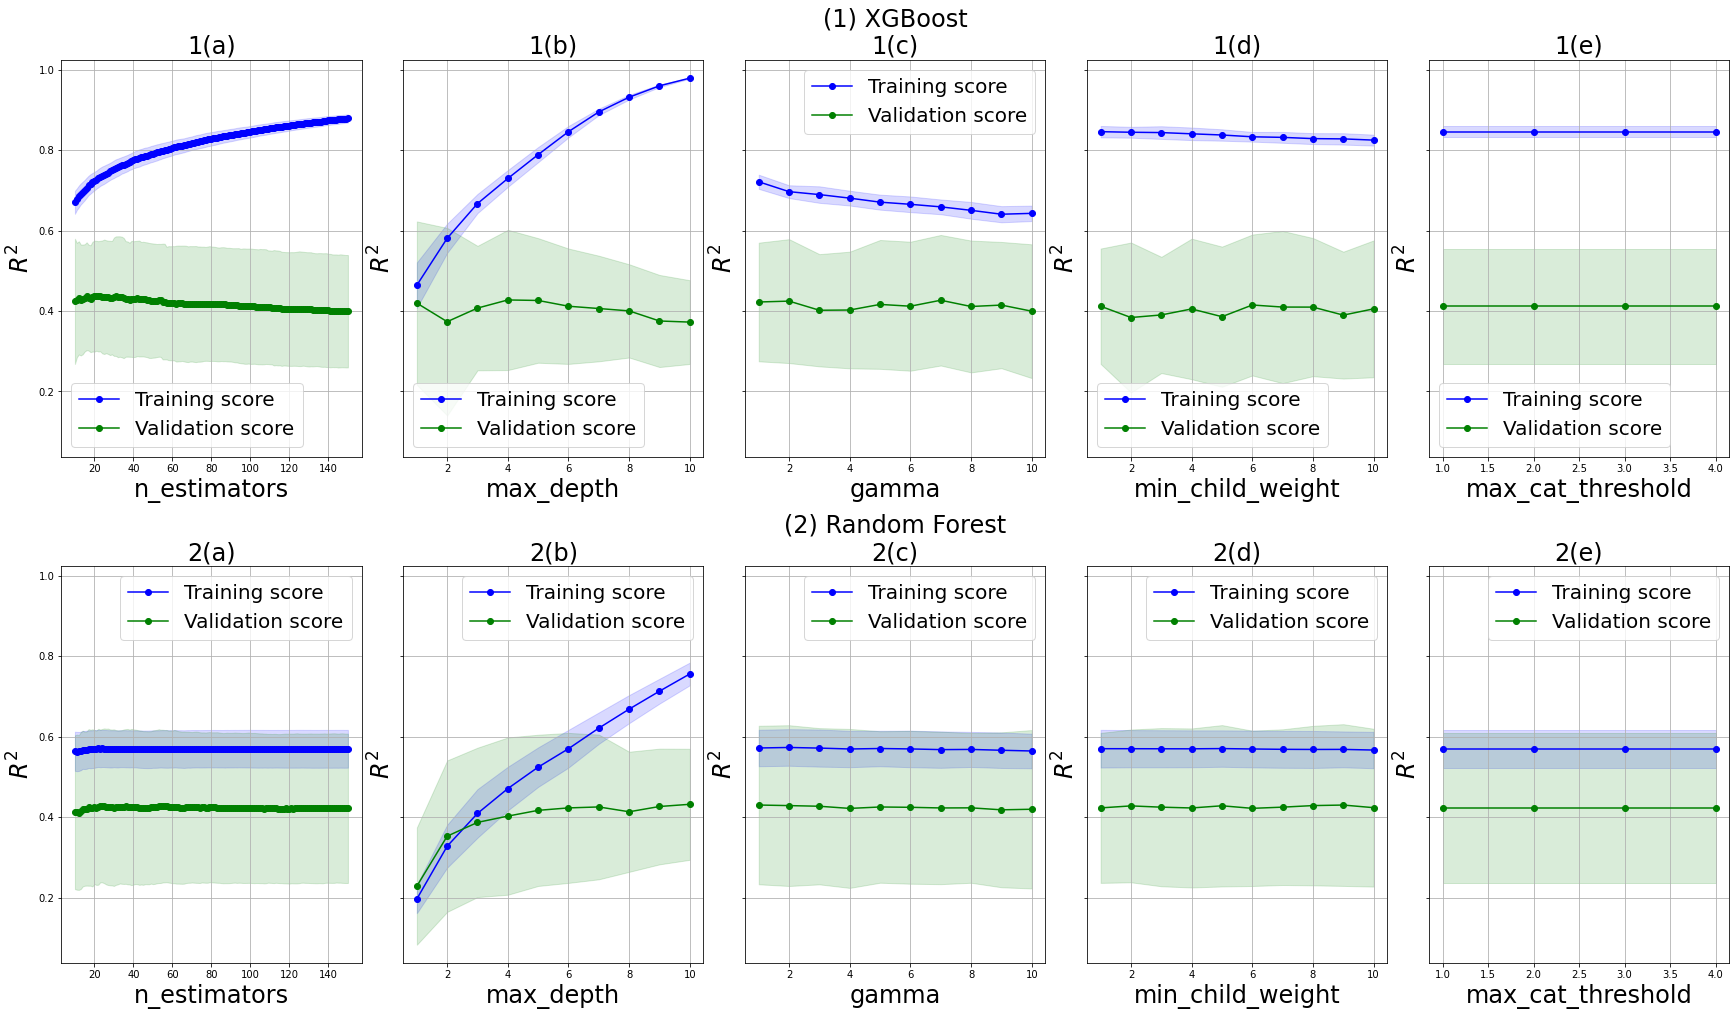

In [8]:
# List of parameters for model complexity tests
param_names  = ['n_estimators', 'max_depth', 'gamma', 'min_child_weight', 'max_cat_threshold'] * 2
param_ranges = [np.arange(10, 151), np.arange(1, 11), np.arange(1, 11), np.arange(1, 11), np.arange(1, 5)] * 2
subtitles = ['1(a)', '1(b)', '(1) XGBoost\n1(c)', '1(d)', '1(e)', 
             '2(a)', '2(b)', '(2) Random Forest\n2(c)', '2(d)', '2(e)']
plt.rcParams.update({'font.size': 20}) # Set font size
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(24,14), sharey=True, constrained_layout=True)
for k, ax in enumerate(axes.flatten()):
    param_name  = param_names[k]
    param_range = param_ranges[k]
    # Calculate validation curves
    if k < ncols: # xgboost in first row
        train_scores, test_scores = validation_curve(
            estimator=xgb, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')
    else: # random forest in second row
        train_scores, test_scores = validation_curve(
            estimator=rf, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')

    # Calculate mean and standard deviation of scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot validation curves
    ax.plot(param_range, train_mean, color="blue", marker="o", label="Training score")
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
    ax.plot(param_range, test_mean, color="green", marker="o", label="Validation score")
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
    ax.set_title(subtitles[k], fontsize=24)
    ax.set_xlabel(param_name, fontsize=24)
    ax.set_ylabel("$R^2$", fontsize=24)
    ax.grid()
    ax.legend(loc="best", fontsize=20)

plt.savefig('graphs/validation_curves/model_complexity.jpg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/validation_curves/model_complexity_300dpi.svg', bbox_inches='tight', dpi=300)
plt.savefig('graphs/validation_curves/model_complexity.svg', bbox_inches='tight', dpi=1000)

### Random Noise

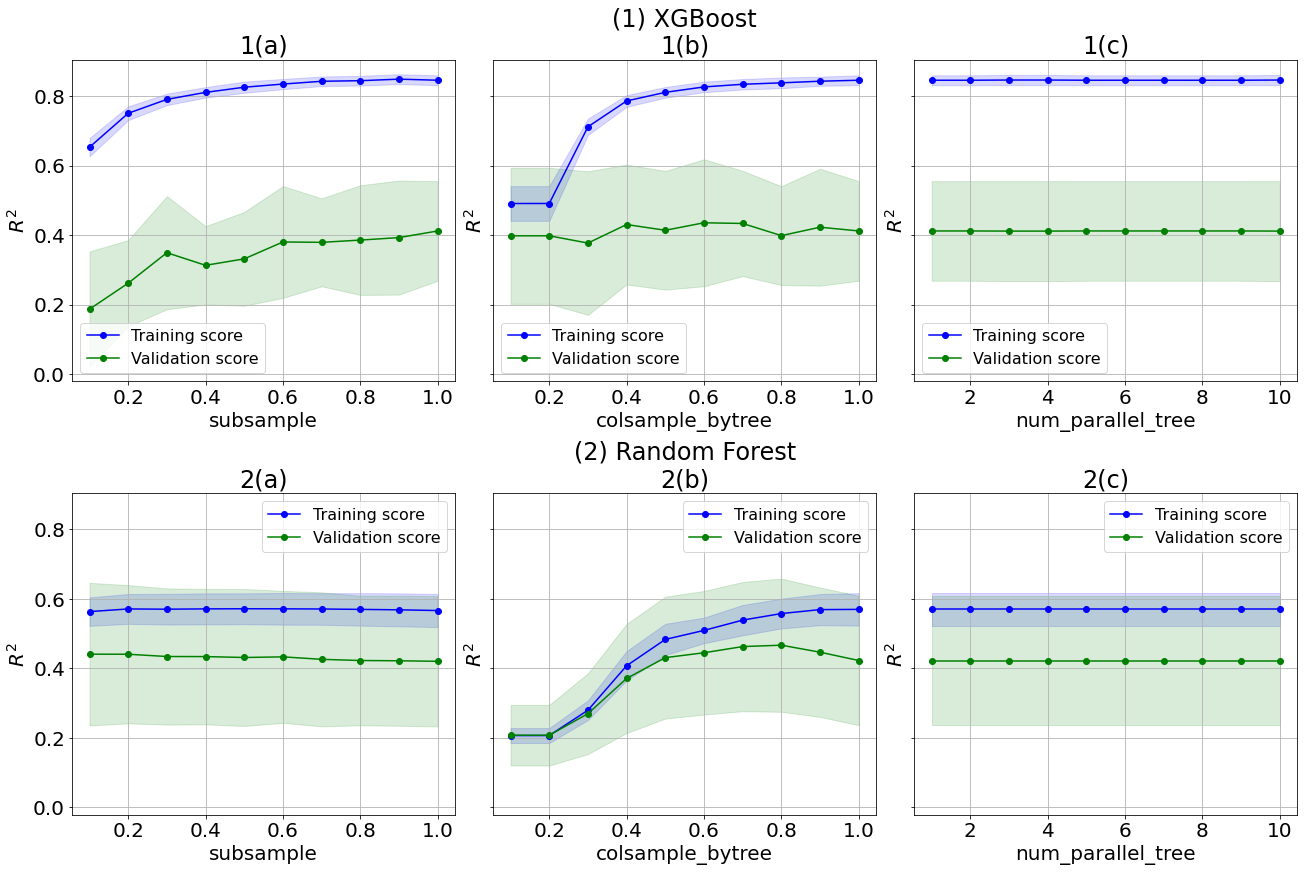

In [9]:
# List of parameters for model random noise tests
param_names  = ['subsample', 'colsample_bytree', 'num_parallel_tree'] * 2
param_ranges = [np.linspace(0.1, 1.0, 10), np.linspace(0.1, 1.0, 10), np.arange(1, 11)] * 2
subtitles = ['1(a)', '(1) XGBoost\n1(b)', '1(c)', 
             '2(a)', '(2) Random Forest\n2(b)', '2(c)']
plt.rcParams.update({'font.size': 20}) # Set font size
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18,12), sharey=True, constrained_layout=True)
for k, ax in enumerate(axes.flatten()):
    param_name  = param_names[k]
    param_range = param_ranges[k]
    # Calculate validation curves
    if k < ncols: # xgboost in first row
        train_scores, test_scores = validation_curve(
            estimator=xgb, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')
    else: # random forest in second row
        train_scores, test_scores = validation_curve(
            estimator=rf, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')

    # Calculate mean and standard deviation of scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot validation curves
    ax.plot(param_range, train_mean, color="blue", marker="o", label="Training score")
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
    ax.plot(param_range, test_mean, color="green", marker="o", label="Validation score")
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
    ax.set_title(subtitles[k])
    ax.set_xlabel(param_name)
    ax.set_ylabel("$R^2$")
    ax.grid()
    ax.legend(loc="best", fontsize=16)

plt.savefig('graphs/validation_curves/random_noise.jpg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/validation_curves/random_noise_300.svg', bbox_inches='tight', dpi=300)
plt.savefig('graphs/validation_curves/random_noise.svg', bbox_inches='tight', dpi=1000)

### Regularization (L1 and L2)

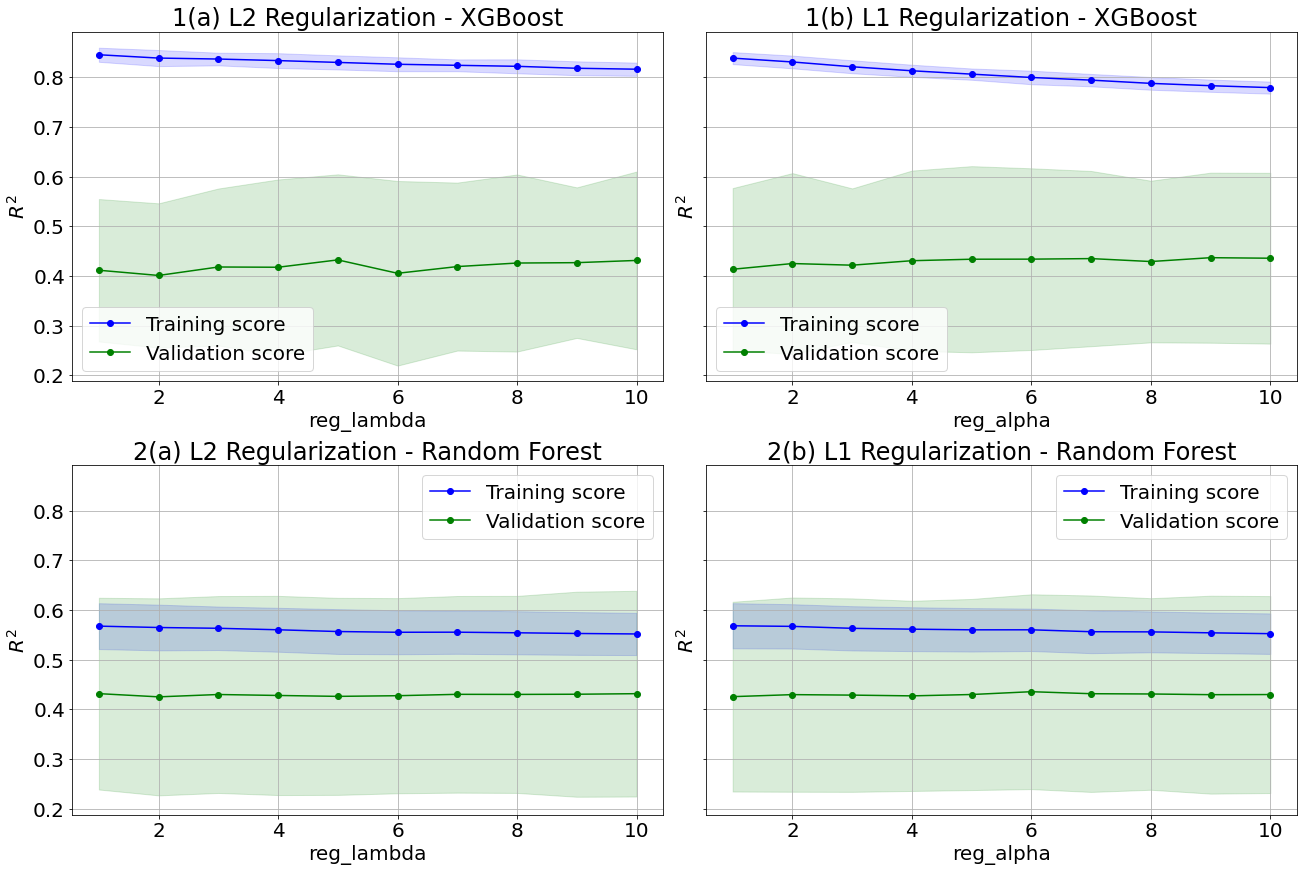

In [10]:
# List of parameters for model random noise tests
param_names  = ['reg_lambda', 'reg_alpha',] * 2
param_ranges = [np.arange(1, 11), np.arange(1, 11)] * 2
subtitles = ['1(a) L2 Regularization - XGBoost', '1(b) L1 Regularization - XGBoost', 
             '2(a) L2 Regularization - Random Forest', '2(b) L1 Regularization - Random Forest']
plt.rcParams.update({'font.size': 20}) # Set font size
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18,12), sharey=True, constrained_layout=True)
for k, ax in enumerate(axes.flatten()):
    param_name  = param_names[k]
    param_range = param_ranges[k]
    # Calculate validation curves
    if k < ncols: # xgboost in first row
        train_scores, test_scores = validation_curve(
            estimator=xgb, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')
    else: # random forest in second row
        train_scores, test_scores = validation_curve(
            estimator=rf, X=X, y=y, param_name=param_name, param_range=param_range, 
            cv=5, scoring="r2", n_jobs=-1, error_score='raise')

    # Calculate mean and standard deviation of scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot validation curves
    ax.plot(param_range, train_mean, color="blue", marker="o", label="Training score")
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
    ax.plot(param_range, test_mean, color="green", marker="o", label="Validation score")
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
    ax.set_title(subtitles[k])
    ax.set_xlabel(param_name)
    ax.set_ylabel("$R^2$")
    ax.grid()
    ax.legend(loc="best")

plt.savefig('graphs/validation_curves/regularization.jpg', bbox_inches='tight', dpi=1000)
plt.savefig('graphs/validation_curves/regularization_300.svg', bbox_inches='tight', dpi=300)
plt.savefig('graphs/validation_curves/regularization.svg', bbox_inches='tight', dpi=1000)